# A Teaser Example

Let's directly look at a very reduced example that highlights some of the key capabilities of physics-based learning approaches.

Take a look at the following picture - the desired solution is shown in light gray. If we don't take care we'll learn approximations like the red one shown in the left, which are completely off! With an improved learning setup, ideally by using a discretized numerical solver, we can at least accurately represent a part of the solutions (green on the right).

```{figure} resources/intro-teaser-side-by-side.png
---
height: 240px
name: intro-teaser-side-by-side
---
Side by side - supervised versus differentiable physics training.
```


## Differentiable physics

Let's illustrate the properties of deep learning via differentiable physics (DP) with a simple example: We'd like to find an unknown function $f^*$ that generates solutions from a space $Y$ that we're interested in. 

Let's additionally assume we have a generic differential equation $\mathcal P^*: Y \to X$ (our _model_ equation), that encodes a property of the solutions, here modeled in terms of a mapping to the input space $X$. Alternatively, we could imagine $X$ representing future solutions that we're looking for (then $\mathcal P^*$ would model a time evolution), or it could be a constraint for conservation of mass (then $\mathcal P^*$ would measure divergence).

Using a neural network $f$ to learn the unknown and ideal function $f^*$, we could turn to classic _supervised_ training to obtain $f$ by collecting data. This classical setup requires a dataset by sampling $x$ from $X$ and adding the corresponding solutions $y$ from $Y$. We could obtain these, e.g., by classical numerical techniques. Then we train the NN $f$ in the usual way using this dataset. 

In contrast to this, differentiable physics takes advantage of the fact that we can directly use a discretized version of the physical model $\mathcal P$ and employ it to guide the training of $f$. I.e., we want $f$ to _interact_ with our _simulator_ $\mathcal P$. This can vastly improve the learning, as we'll illustrate below with a super simple example, and later on with more complex ones.

(Note that it order for the DP approach to work, $\mathcal P$ has to differentiable, as implied by the name. These differentials, in the form of a gradient, are what's driving the learning process.)


## Finding the inverse function of a parabola

To illustrate these two approaches, we consider the following simplified setting: Given the function $\mathcal P: y\to y^2$ for $y$ in the inverval $[0,1]$, find the unknown function $f$ such that $\mathcal P(f(x)) = x$ for all $x$ in $[0,1]$. Note that the _discretization_ here is simply given by representing the $x$ and $y$ via floating point numbers in the computer.

We know possible solutions for $f$ are the positive or negative square root function (for completeness: piecewise combinations would also be possible).

We can try to solve this by using a neural network to approximate the inverse mapping $f$.
Let's start with the supervised approach.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

For supervised training, we need a method to find for each datapoint the corresponding solution of the above problem. We simply use our solver $\mathcal P$ for the problem to pre-compute these solutions: We randomly choose between the positive and the negative square root. This makes sense because in the generic case, when we require optimization techniques to do this step, these methods are not expected to favor one particular mode in multimodal solutions.

In [2]:
# X-Data
N = 200
X = np.random.random(N)

In [3]:
# Generation Y-Data
sign = (- np.ones((N,)))**np.random.randint(2,size=N)
Y = np.sqrt(X) * sign

Now we can define a network, loss, and training configuration. We'll use a simple `keras` model with three hidden layers, ReLU activations.

In [4]:
# Neural network
act = tf.keras.layers.ReLU()
model_sv = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, activation=act),
  tf.keras.layers.Dense(8, activation=act),
  tf.keras.layers.Dense(1,activation='linear')])

In [5]:
# Loss function
Loss_sv = tf.keras.losses.MeanSquaredError()
model_sv.compile(optimizer='adam', loss=Loss_sv)

In [6]:
# Training
results_sv = model_sv.fit(X, Y, epochs=5, batch_size= 5,verbose=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 200 samples
Epoch 1/5
200/200 [==============================] - 1s 3ms/sample - loss: 0.5135
Epoch 2/5
200/200 [==============================] - 0s 355us/sample - loss: 0.5097
Epoch 3/5
200/200 [==============================] - 0s 402us/sample - loss: 0.5077
Epoch 4/5
200/200 [==============================] - 0s 399us/sample - loss: 0.5066
Epoch 5/5
200/200 [==============================] - 0s 303us/sample - loss: 0.5054


As both model and data set are very small, the training converges very quickly, but if we inspect the predictions of the network, we can see that it nowhere near the solution we wer hoping to find: it averages between the data points on both sides of the x-axis and therefore, fails to find satisfying solutions to our above problem.

The following plots nicely highlights this: it shows the data in blue, and the supervised solution in red. 

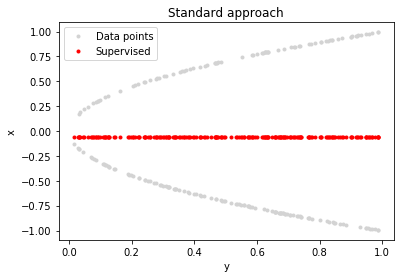

In [7]:
# Results
plt.plot(X,Y,'.',label='Data points', color="lightgray")
plt.plot(X,model_sv.predict(X),'.',label='Supervised', color="red")
plt.xlabel('y')
plt.ylabel('x')
plt.title('Standard approach')
plt.legend()
plt.show()

😱 This is obviously completely wrong! The red solution is nowhere near one of the two modes of our solution shown in blue.

Note that the line is often not perfectly at zero, which is where the two modes of the solution should average out in the continuous setting. This is caused by the relatively coarse sampling with only 200 points in this example.
<br>

---

## Finding f via a Differentiable Physics approach

Now let's apply the differentiable physics approach: we'll directly include our discretized model $\mathcal P$ in the training. 

There is no real data generation step; we only need to sample from the $[0,1]$ interval. We'll simply keep the same $x$ locations used in the previous case.

In [8]:
# X-Data
# X = X , we can directly re-use the X from above, nothing has changed...

In [9]:
# Model
model_dp = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, activation=act),
  tf.keras.layers.Dense(8, activation=act),
  tf.keras.layers.Dense(1,activation='linear')])

This loss function is the **crucial** point now: we directly incorporate the function f into the loss. In this simple case, the `Loss_dp` function simply computes the square of the prediction `y_pred`. 

Later on, a lot more could happen here: we could evaluate finite difference stencils on the predicted solution, or compute a whole implicit time-integration step of a solver. Note: here we effectively have a simple residual equation $y_{\text{pred}}^2 - y_{\text{true}} = 0$ which we are minimizing via a _mean-squared error_. It's not necessary to make it so simple: the more knowledge and numerical methods we can incorporate, the better we can guide the training process.

In [10]:
#Loss
mse = tf.keras.losses.MeanSquaredError()
def Loss_dp(y_true, y_pred):
    return mse(y_true,y_pred**2)

model_dp.compile(optimizer='adam', loss=Loss_dp)

In [11]:
#Training
results_dp = model_dp.fit(X, X, epochs=5, batch_size= 5,verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 200 samples
Epoch 1/5
200/200 [==============================] - 0s 1ms/sample - loss: 0.2711
Epoch 2/5
200/200 [==============================] - 0s 282us/sample - loss: 0.0733
Epoch 3/5
200/200 [==============================] - 0s 321us/sample - loss: 0.0028
Epoch 4/5
200/200 [==============================] - 0s 322us/sample - loss: 0.0013
Epoch 5/5
200/200 [==============================] - 0s 335us/sample - loss: 0.0012


Now the network actually has learned a good inverse of the parabola function! The following plot shows the solution in green.

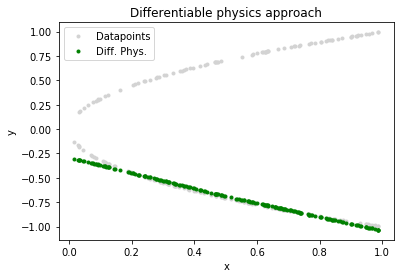

In [12]:
# Results
plt.plot(X,Y,'.',label='Datapoints', color="lightgray")
#plt.plot(X,model_sv.predict(X),'.',label='Supervised', color="red") # optional for comparison
plt.plot(X,model_dp.predict(X),'.',label='Diff. Phys.', color="green") 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Differentiable physics approach')
plt.legend()
plt.show()

This looks much better 😎, at least in the range of 0.2 to 1. 

What has happened here?

- We've prevented an undesired averaging of multiple modes in the solution by evaluating our discrete model w.r.t. current prediction of the network, rather than using a pre-computed solution. This let's us find the best single mode near the network prediction, and prevents an averaging of the modes that are contained in the solution manifold.

- We're still only getting one side of the curve! This is to be expected, because we're representing the solutions with a deterministic function. Hence we can only represent a single mode. Interestingly, whether it's the top or bottom mode is determined by the random initialization of the weights in $f$ - run the example a couple of time to see this effect in action. To capture multiple modes we'd need to extend the model to capture the full distribution of the outputs and parametrize it with additional dimensions.

- The region with $x$ near zero is typically still off in this example. The is caused by the larger curvature in this region, and the even sampling with points along $x$. This could be alleviated with more points, a larger network, and potentially longer training.


## Discussion

It's a very simple example, but it very clearly shows a failure case for supervised learning. While it might seem very artificial on first sight, many practical PDEs exhibit a variety of these modes, and often it's not clear where (and how many) exist in the solution manifold we're interested in. Then supervised learning is very dangerous - we might simply and unknowingly _blur_ out these different modes.

A good examples are bifurcations in fluid flows - the smoke rising above a candle will start out straight, and then, due to tiny perturbations in its motion, start oscillating in a random direction. The images below illustrate this case via _numerical perturbations_: the perfectly symmetric setup will start turning left or right, depending on how the approximation errors build up. Similarly, we'll have different modes in all our numerical solutions, and typically it's important to recover them, rather than averaging out. Hence, we'll show how to leverage training via _differentiable physics_ in the following chapters for more practical and complex cases.



## Next steps

- The example above is itentionally using a fairly "bad" setup. Try to find out how to obtain a solution such as the green one shown in the very first image at the top.

- Or you can try extending the setup to a 2D case, i.e. a paraboloid. Given the function $\mathcal P:(y_1,y_2)\to y_1^2+y_2^2$, find an inverse function $f$ such that $\mathcal P(f(x)) = x$ for all $x$ in $[0,1]$.